In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


In [4]:
train = pd.read_csv('./data/diamonds_train.csv')
test = pd.read_csv('./data/diamonds_predict.csv')
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [5]:
target = 'price'
cat_features = ['cut', 'color', 'clarity']
num_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

for cat_feat in cat_features:
    train[cat_feat] = train[cat_feat].astype('category')
    test[cat_feat] = test[cat_feat].astype('category')

features = cat_features + num_features   

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(train)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [8]:
X_train.shape, X_test.shape

((30341, 9), (10114, 9))

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [10]:
numeric_transformer = \
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # how to fill missing data
                ('scaler', StandardScaler())]) # transform to a standard distribution (mean and variance)

categorical_transformer = \
Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]) # convert the values to 0 and 1

preprocessor = \
ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                ('cat', categorical_transformer, cat_features)])

In [11]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import ensemble

In [39]:
models = [DummyRegressor(),
          KNeighborsRegressor(),
          linear_model.LinearRegression(), 
          linear_model.Lasso(),
          linear_model.Ridge(),
          linear_model.ElasticNet(),
          ensemble.GradientBoostingRegressor(),
          ensemble.RandomForestRegressor(),
          ensemble.ExtraTreesRegressor()]

models_names = ['DummyReg','KNeighborsReg', 'Linear Reg', 'Lasso','Ridge','ElasticNet','GradiBoostReg','RandForestReg','ExtraTreesReg']

In [23]:
R_squared = []
mean_squared = []


for model in models:
    pipe = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('model', model)
    ])
    fits = pipe.fit(X_train,y_train)
    R_squared.append(metrics.r2_score(y_test, fits.predict(X_test)))
    mean_squared.append(metrics.mean_squared_error(y_test, fits.predict(X_test)))
    


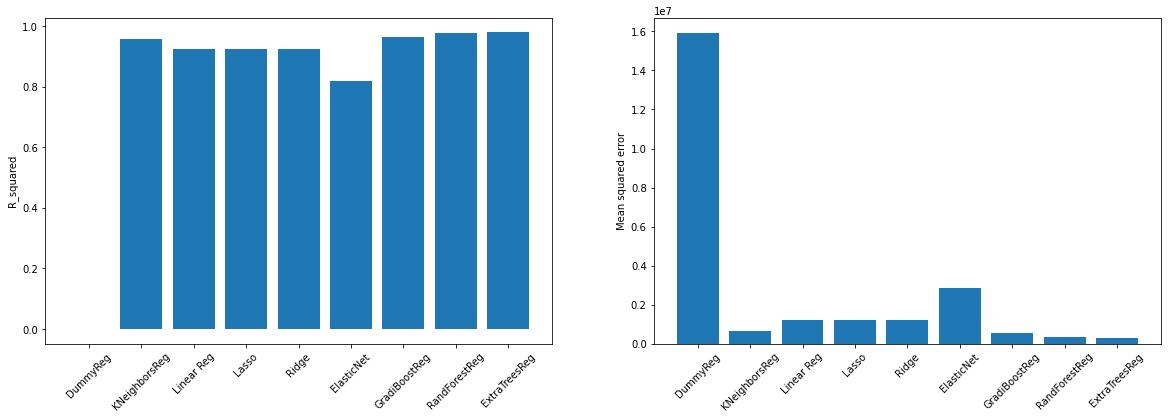

In [40]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(20,6))
ax1.bar(models_names, R_squared)
ax1.set_ylabel('R_squared')
ax1.xaxis.set_tick_params(rotation=45)
ax2.bar(models_names, mean_squared)
ax2.set_ylabel('Mean squared error');
ax2.xaxis.set_tick_params(rotation=45)


In [41]:
f.savefig('Compare_models')

In [ ]:
# The best models for prediction seem to be Random Forest Regressor or Extra Trees Regressor

In [12]:
mod = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ensemble.RandomForestRegressor(n_estimators=110, min_samples_leaf=1))])

mod_fit = mod.fit(X_train, y_train)

mod_fit.score(X_test,y_test)


In [26]:
y_predict = mod_fit.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predict, squared = False)

582.7622865320039

In [ ]:
# optimize parameters with the help of cross validation

In [32]:
from sklearn.model_selection import GridSearchCV

# cross validation folds
folds=3

# set parameter range for grid search
params = {'model__n_estimators': [100, 110, 120], 'model__min_samples_leaf': [1,2]}

grids = GridSearchCV(mod, param_grid=params, cv=folds)
grids_fit = grids.fit(X_train, y_train)

print('Best choice of parameter:', grids_fit.best_params_)


Best choice of parameter: {'model__min_samples_leaf': 1, 'model__n_estimators': 110}


In [1]:
# check stability of the model

In [17]:
from sklearn.model_selection import cross_validate

mod_cross_val = cross_validate(mod, train[features], y=train[target], cv=5, return_train_score=True)

print('Average train score:', mod_cross_val['train_score'].mean().round(4))
print('Average test score:',  mod_cross_val['test_score'].mean().round(4))


Average train score: 0.9971
Average test score: 0.9788
